[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/cmaes.ipynb)

# Optimizing with CMA-ES in Jax

This notebook shows how to use QDax to find performing parameters on Rastrigin and Sphere problems with [CMA-ES](https://arxiv.org/pdf/1604.00772.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ES optimizer
- how to launch a certain number of optimizing steps
- how to visualise the optimization process

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

2025-10-27 21:01:15.665344: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Set the hyperparameters

In [2]:
#@title Hyperparameters
#@markdown ---
num_iterations = 1000 #@param {type:"integer"}
num_dimensions = 2 #@param {type:"integer"}
batch_size = 36 #@param {type:"integer"}
num_best = 18 #@param {type:"integer"}
sigma_g = 1.0 # 0.5 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
optim_problem = "rastrigin" #@param["rastrigin", "sphere"]
#@markdown ---

## Define the fitness function - choose rastrigin or sphere

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

if optim_problem == "sphere":
    fitness_fn = sphere_scoring
elif optim_problem == "rastrigin":
    fitness_fn = jax.vmap(rastrigin_scoring)
else:
    raise Exception("Invalid opt function name given")

## Define a CMA-ES optimizer instance

In [4]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions,
    fitness_function=fitness_fn,
    mean_init=jnp.zeros((num_dimensions,)),
    init_sigma=sigma_g,
    delay_eigen_decomposition=True,
)

## Init the CMA-ES optimizer state

In [5]:
state = cmaes.init()
random_key = jax.random.PRNGKey(1)

## Run optimization iterations

In [6]:
# %%time

means = [state.mean]
covs = [(state.sigma**2) * state.cov_matrix]

iteration_count = 0
for _ in range(num_iterations):
    iteration_count += 1
    
    # sample
    samples, random_key = cmaes.sample(state, random_key)
    
    # udpate
    state = cmaes.update(state, samples)
    
    # check stop condition
    stop_condition = cmaes.stop_condition(state)

    if stop_condition:
        break
    
    # store data for plotting
    means.append(state.mean)
    covs.append((state.sigma**2) * state.cov_matrix)
        
print("Num iterations before stop condition: ", iteration_count)

Num iterations before stop condition:  53


## Check final fitnesses and distribution mean

In [7]:
# checking final fitness values
fitnesses = fitness_fn(samples)

print("Min fitness in the final population: ", jnp.min(fitnesses))
print("Mean fitness in the final population: ", jnp.mean(fitnesses))
print("Max fitness in the final population: ", jnp.max(fitnesses))

# checking mean of the final distribution
print("Final mean of the distribution: \n", means[-1])
# print("Final covariance matrix of the distribution: ", covs[-1])

Min fitness in the final population:  -0.9949608
Mean fitness in the final population:  -0.9949591
Max fitness in the final population:  -0.994957
Final mean of the distribution: 
 [1.0530418 2.048003 ]


## Visualization of the optimization trajectory

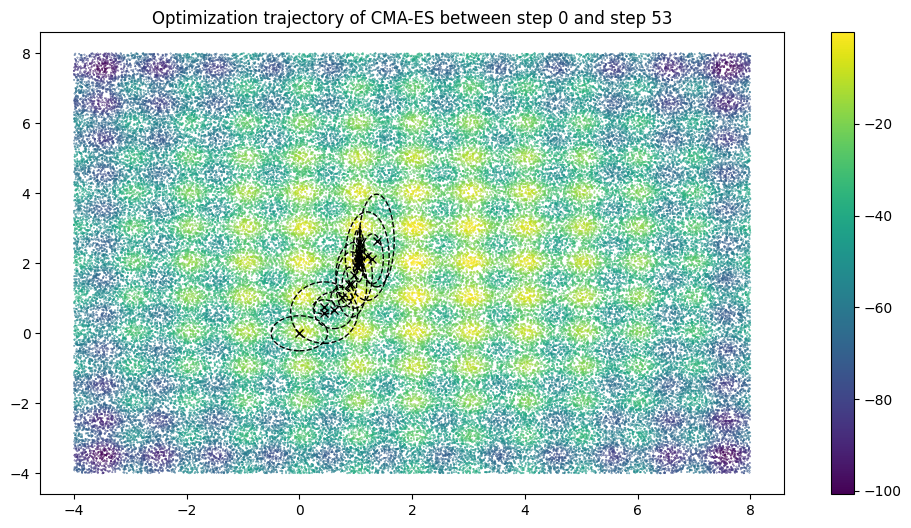

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))

# sample points to show fitness landscape
random_key, subkey = jax.random.split(random_key)
x = jax.random.uniform(subkey, minval=-4, maxval=8, shape=(100000, 2))
f_x = fitness_fn(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
traj_min = 0
traj_max = iteration_count
for mean, cov in zip(means[traj_min:traj_max], covs[traj_min:traj_max]):
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')
    
ax.set_title(f"Optimization trajectory of CMA-ES between step {traj_min} and step {traj_max}")
plt.show()